Imports & Settings

In [1]:
import sys
import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from tqdm import tqdm

# Add 'src' to python path so we can import our files
sys.path.append('../src')
from dataset import AudioDataset
from vae import VAE

# Configuration
# NOTE: Ensure these paths match your actual folders
AUDIO_DIR = '../data/audio'  
CSV_PATH = '../data/fma_lyrics_dataset.csv'

BATCH_SIZE = 32
LR = 1e-3
EPOCHS = 10  # Set to 10-20 for a quick test
LATENT_DIM = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Running on: {DEVICE}")

Running on: cpu


Load Data (The Moment of Truth)

In [2]:
# Initialize Dataset
print("Initializing dataset... this might take a minute to check file paths.")
dataset = AudioDataset(CSV_PATH, AUDIO_DIR, duration=30)

if len(dataset) == 0:
    raise ValueError("No files found! Check your AUDIO_DIR path and folder structure.")

# Create Loader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Check one sample to set input dimensions
sample_data = dataset[0]
INPUT_DIM = sample_data.shape[0]
print(f"Input Feature Size: {INPUT_DIM}")

Initializing dataset... this might take a minute to check file paths.
Dataset initialized. Found 3375 valid audio files out of 3375.
Input Feature Size: 16796


Train the VAE

Starting Training...


Epoch 1/10:  23%|██▎       | 24/106 [01:21<04:44,  3.47s/it, loss=0.361]d:\CSE425 Project\notebooks\../src\dataset.py:47: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.target_sample_rate, duration=self.duration)
d:\CSE425 Project\venv\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 10/10: 100%|██████████| 106/106 [05:26<00:00,  3.08s/it, loss=0.181]


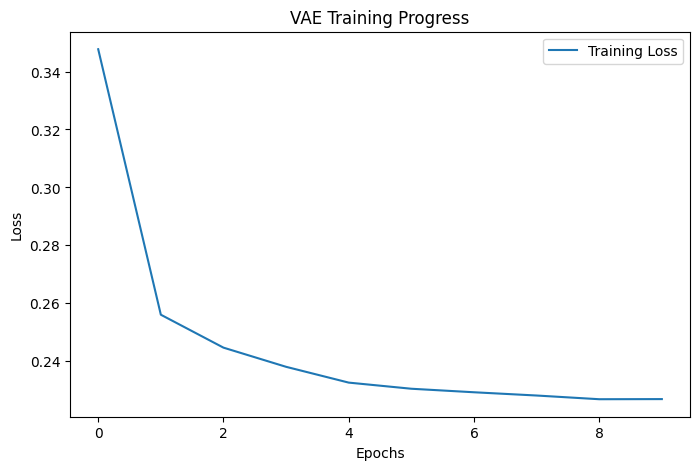

In [3]:
model = VAE(input_dim=INPUT_DIM, latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = torch.nn.MSELoss()

def loss_function(recon_x, x, mu, logvar):
    MSE = loss_fn(recon_x, x)
    # KL Divergence term
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + 0.0001 * KLD

print("Starting Training...")
model.train()
losses = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for batch in progress_bar:
        batch = batch.to(DEVICE)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss = loss_function(recon_batch, batch, mu, logvar)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(losses, label='Training Loss')
plt.title("VAE Training Progress")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Clustering & Analysis

Extracting latent features...
Performing K-Means Clustering...
VAE + K-Means Silhouette Score: 0.2084
Running t-SNE for visualization...


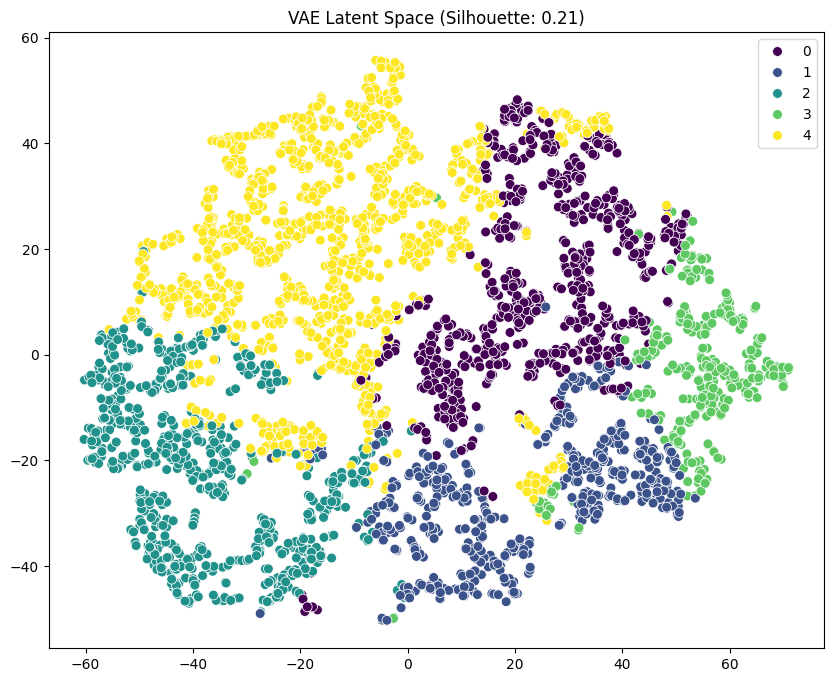

In [4]:
model.eval()
all_latents = []

print("Extracting latent features...")
with torch.no_grad():
    for batch in dataloader:
        batch = batch.to(DEVICE)
        _, mu, _ = model(batch)
        all_latents.append(mu.cpu().numpy())

X_latent = np.concatenate(all_latents, axis=0)

# K-Means Clustering
print("Performing K-Means Clustering...")
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_latent)

# Calculate Scores
sil_score = silhouette_score(X_latent, cluster_labels)
print(f"VAE + K-Means Silhouette Score: {sil_score:.4f}")

# Visualize with t-SNE
print("Running t-SNE for visualization...")
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_latent)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=cluster_labels, palette="viridis", s=50)
plt.title(f"VAE Latent Space (Silhouette: {sil_score:.2f})")
plt.show()

Baseline Comparison (PCA vs VAE)

In [5]:
from sklearn.decomposition import PCA

print("\n--- Running Baseline Comparison (PCA) ---")

# 1. Flatten Data for PCA (using the same data we fed the VAE)
# We need to collect all data from the dataloader again or use a subset if RAM is tight
all_data = []
print("Gathering raw data for PCA...")
for batch in dataloader:
    all_data.append(batch.numpy())
    
X_raw = np.concatenate(all_data, axis=0)

# 2. Apply PCA
# We reduce to the SAME dimension as the VAE latent space (32) for a fair fight
pca = PCA(n_components=LATENT_DIM)
X_pca = pca.fit_transform(X_raw)

# 3. Cluster PCA features
kmeans_pca = KMeans(n_clusters=5, random_state=42)
pca_labels = kmeans_pca.fit_predict(X_pca)

# 4. metrics
pca_sil_score = silhouette_score(X_pca, pca_labels)

print(f"\n--- Results Table ---")
print(f"VAE Silhouette Score: {sil_score:.4f}")
print(f"PCA Silhouette Score: {pca_sil_score:.4f}")

if sil_score > pca_sil_score:
    print("SUCCESS: VAE outperformed the PCA baseline!")
else:
    print("NOTE: PCA performed better. This is common with simple VAEs on raw audio.")
    print("To improve VAE, we will add Convolutional layers in the Medium Task.")


--- Running Baseline Comparison (PCA) ---
Gathering raw data for PCA...


d:\CSE425 Project\notebooks\../src\dataset.py:47: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.target_sample_rate, duration=self.duration)
d:\CSE425 Project\venv\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)



--- Results Table ---
VAE Silhouette Score: 0.2084
PCA Silhouette Score: 0.1478
SUCCESS: VAE outperformed the PCA baseline!
